# Implémentation du papier : SRINIVAS, BABU: DATA-FREE PARAMETER PRUNING FOR DEEP NEURAL NETWORKS 

Lien vers le papier: https://arxiv.org/pdf/1507.06149.pdf

Le but est de faire de la compression de réseaux de neurones.


## Exemple sur Iris

Nous allons faire un petit modele de 4 * 5000 * 3 pour expliquer les principes.
La principale limitation est qu'il faut un réseau "fully connected" pour pouvoir appliquer la démonstration du raisonnement de l'article.


# Définition du model

In [1]:
import torch
import torch.nn as nn


# Définir l'architecture du modèle
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 5)
        self.fc3 = nn.Linear(5, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Dataset

Comme à notre habitude, nous faisons un set de train et de test avec notre dataset - ici IRIS

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_data = load_iris()
X = iris_data.data
y = iris_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

### Iris sans optimisation

On prends ici notre fonction de cout classique et notre optimiseur classique.

In [4]:
import torch.optim as optim

model = Net()

# Définir l'optimiseur et la fonction de coût
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

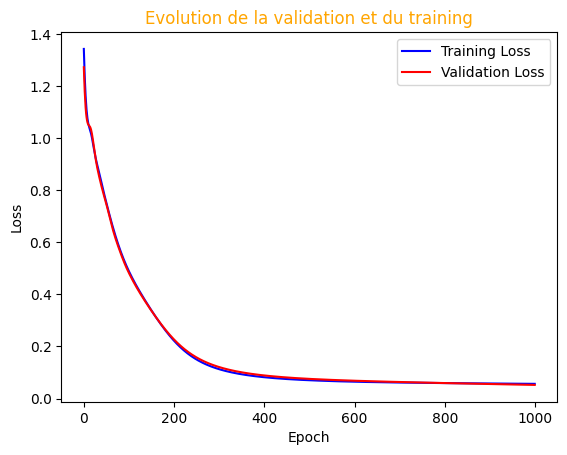

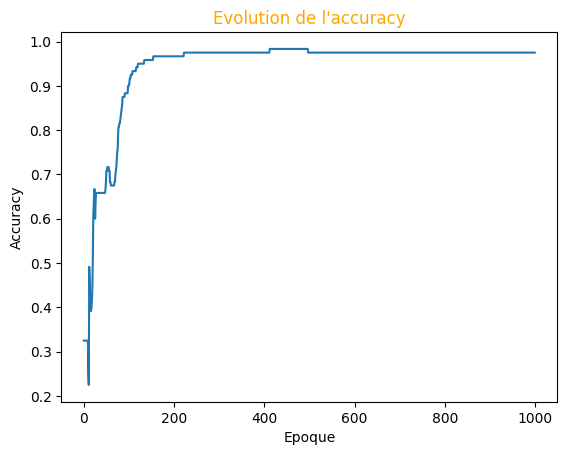

Nous avons donc un temps de: 0.3105349540710449


In [5]:
import matplotlib.pyplot as plt
import time

# Initialiser les tableaux pour stocker les métriques d'entraînement
train_losses = []
train_accuracies = []
validation = []

# Entraîner le modèle
time0 = time.time()
for epoch in range(1000):
    # Propager les données d'entraînement à travers le modèle
    y_pred = model(X_train_tensor)

    # Fonction de coût
    loss = criterion(y_pred, y_train_tensor)

    # Accuracy
    accuracy = (y_pred.argmax(1) == y_train_tensor).float().mean()

    # Validation
    y_val_pred = model(X_test_tensor)
    val_loss = criterion(y_val_pred, y_test_tensor)

    # Stocker les métriques d'entraînement pour cette époque
    train_losses.append(loss.item())
    train_accuracies.append(accuracy.item())
    validation.append(val_loss.item())

    # Réinitialiser les gradients et effectuer une étape d'optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

time1 = time.time()

# Afficher les courbes d'accuracy et de loss
plt.figure()
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(validation, label='Validation Loss', color='red')
plt.title('Evolution de la validation et du training', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies)
plt.xlabel('Epoque')
plt.ylabel('Accuracy')
plt.title('Evolution de l\'accuracy', color='orange')
plt.show()

print("Nous avons donc un temps de:", time1 - time0)

In [6]:
print(model.fc1.weight.shape)
print(model.fc2.weight.shape)
print(model.fc3.weight.shape)

torch.Size([50, 4])
torch.Size([5, 50])
torch.Size([3, 5])


### Iris avec prunning

In [7]:
from numba import jit

@jit
def calculate_saliency(weight_i, bias_i, weight_j, bias_j, coef_j):
    epsilon = weight_i - weight_j + bias_i - bias_j
    saliency = (coef_j ** 2) * torch.norm(epsilon, 2) ** 2
    return saliency

In [8]:
# from numba import jit

# @jit
def get_matrix_saliency(weights, bias, coefs):
    # Calculate the saliency matrix for the given layer
    saliency_matrix = torch.empty((weights.shape[0], weights.shape[0]))
    for i in range(weights.shape[0]):
        for j in range(weights.shape[0]):
            saliency_matrix[i][j] = calculate_saliency(weights[i], bias[i], weights[j], bias[j], coefs[j])
            #calculate_saliency(weights[i], bias[i], weights[j], bias[j], coefs[j])
    return saliency_matrix


#Cette fonction sert à mettre à jour la matrice une fois que nous avons enlever un poid
#@jit
# def update_matrix_saliency(saliency_matrix, j, weights, bias, coefs):
#     new_saliency_matrix = saliency_matrix
#     for i in range(weights.shape[0]):
#       new_saliency_matrix[i][j] = calculate_saliency(weights[i], bias[i], weights[j], bias[j], coefs[j]) 
#     return new_saliency_matrix

def get_smallest_saliency_id(saliency_matrix):
    lowest_saliency = float("inf")
    lowest_saliency_indices = (0, 0)

    for i in range(saliency_matrix.shape[0]):
        for j in range(saliency_matrix.shape[0]):
            #On ne veut pas la diagonale
            if j != i:
                # Calculate the saliency for the current pair of weight sets
                current_saliency = saliency_matrix[i][j]
                # Update the lowest saliency and the corresponding indices if necessary
                if current_saliency < lowest_saliency:
                    lowest_saliency = current_saliency
                    lowest_saliency_indices = (i, j)
    return lowest_saliency_indices


def update_model_and_saliency_matrix(model, saliency_matrix):
    id = get_smallest_saliency_id(saliency_matrix)
    i, j = id[0], id[1]

    weights = model.fc1.weight
    bias = model.fc1.bias
    coefs = model.fc2.weight[0]

    model.fc1.weight.data = torch.cat((weights[:j], weights[j + 1:]))
    model.fc1.bias.data = torch.cat((bias[:j], bias[j + 1:]))

    for nb in range(model.fc2.weight.shape[0]):
        if nb == 0:
            model.fc2.weight.data[nb][i] += model.fc2.weight.data[nb][j]
            new_fc2 = torch.cat((model.fc2.weight.data[nb][:j], model.fc2.weight.data[nb][j + 1:]))
        else:
            model.fc2.weight.data[nb][i] += model.fc2.weight.data[nb][j]
            new_fc2 = torch.cat(
                (new_fc2, torch.cat((model.fc2.weight.data[nb][:j], model.fc2.weight.data[nb][j + 1:]))))

    model.fc2.weight.data = torch.reshape(new_fc2, [5, int(int(len(new_fc2)) / 5)])

    # Update the saliency matrix by removing the j-th column and row
    saliency_matrix = torch.cat((saliency_matrix[:i], saliency_matrix[i + 1:]))
    saliency_matrix = torch.cat((saliency_matrix[:, :j], saliency_matrix[:, j + 1:]), dim=1)

    weights = model.fc1.weight
    bias = model.fc1.bias
    coefs = model.fc2.weight[0]

    # Update the saliency values for the remaining weight pairs
    for k in range(saliency_matrix.shape[0]):
        saliency_matrix[k][j] = calculate_saliency(weights[k], bias[k], weights[i], bias[i], coefs[i])

    return saliency_matrix

Cette fonctione est utile pour débug

In [9]:
# from numba import jit

# @jit
def get_saliency_smallest_id(weights, bias, coefs):
    # Initialize the lowest saliency and the corresponding indices
    lowest_saliency = float("inf")
    lowest_saliency_indices = (0, 0)

    for i in range(weights.shape[0]):
        for j in range(weights.shape[0]):
            #On ne veut pas la diagonale
            if j != i:
                # Calculate the saliency for the current pair of weight sets
                current_saliency = calculate_saliency(weights[i], bias[i], weights[j], bias[j], coefs[j])
                # Update the lowest saliency and the corresponding indices if necessary
                if current_saliency < lowest_saliency:
                    lowest_saliency = current_saliency
                    lowest_saliency_indices = (i, j)
    return lowest_saliency_indices

In [10]:
#Exemple
#sortie 0

# print(bias.shape)
# print(weights.shape)
# print(coefs.shape)

#print(calculate_saliency(weights[0],bias[0], weights[5], bias[5], coefs)) #work because we selected one point, we have to select one
weights = model.fc1.weight
bias = model.fc1.bias
coefs = model.fc2.weight[0]

print(get_matrix_saliency(weights, bias, coefs))
print(get_saliency_smallest_id(weights, bias, coefs))
matrix = get_matrix_saliency(weights, bias, coefs)
print(torch.min(matrix))

print(get_smallest_saliency_id(get_matrix_saliency(weights, bias, coefs)))

/var/folders/xq/xrldc_yx08z24kxrr3bb8mk80000gn/T/ipykernel_97982/3671225767.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "calculate_saliency" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/xq/xrldc_yx08z24kxrr3bb8mk80000gn/T/ipykernel_97982/3671225767.py (5)

File "../../../../../var/folders/xq/xrldc_yx08z24kxrr3bb8mk80000gn/T/ipykernel_97982/3671225767.py", line 5:
<source missing, REPL/exec in use?>

  @jit
/Users/guillaumelarue/PycharmProjects/DNN/venv/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "calculate_saliency" was compiled in object mode without forceobj=True.

File "../../../../../var/folders/xq/xrldc_yx08z24kxrr3bb8mk80000gn/T/ipykernel_97982/3671225767.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/guillaumelarue/PycharmProjects/DNN/venv/lib/python3.9/site-package

tensor([[0.0000, 0.0003, 0.0259,  ..., 0.0039, 0.0021, 0.0354],
        [0.0028, 0.0000, 0.0299,  ..., 0.0087, 0.0016, 0.0426],
        [0.0147, 0.0020, 0.0000,  ..., 0.0555, 0.0114, 0.1384],
        ...,
        [0.0011, 0.0003, 0.0280,  ..., 0.0000, 0.0007, 0.0665],
        [0.0022, 0.0002, 0.0212,  ..., 0.0024, 0.0000, 0.0665],
        [0.0041, 0.0006, 0.0283,  ..., 0.0270, 0.0073, 0.0000]],
       grad_fn=<CopySlices>)
(4, 36)
tensor(0., grad_fn=<MinBackward1>)
(4, 36)


tensor(0.9250)


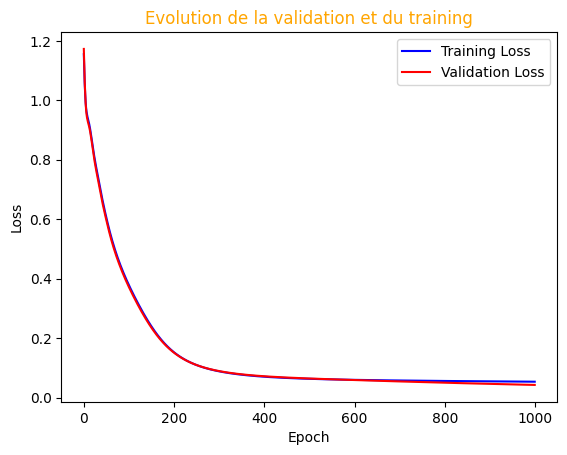

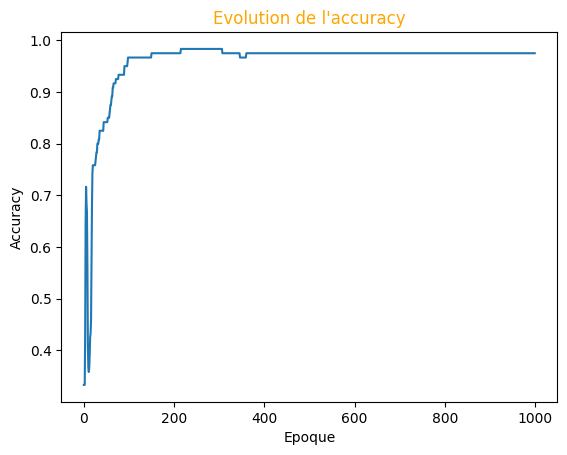

Nous avons donc un temps de: 0.543524980545044


In [22]:
import matplotlib.pyplot as plt
import time

model = Net()

# Définir l'optimiseur et la fonction de coût
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Initialiser les tableaux pour stocker les métriques d'entraînement
train_losses = []
train_accuracies = []
validation = []

# Entraîner le modèle
time0 = time.time()
for epoch in range(1000):
    # Propager les données d'entraînement à travers le modèle
    y_pred = model(X_train_tensor)

    #fonction de coût
    loss = criterion(y_pred, y_train_tensor)

    #Accuracy
    accuracy = (y_pred.argmax(1) == y_train_tensor).float().mean()

    #validation
    y_val_pred = model(X_test_tensor)
    # print(y_val_pred)
    val_loss = criterion(y_val_pred, y_test_tensor)

    # Stocker les métriques d'entraînement pour cette époque
    train_losses.append(loss.item())
    train_accuracies.append(accuracy.item())
    validation.append(val_loss.item())

    # Réinitialiser les gradients et effectuer une étape d'optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

weights = model.fc1.weight
bias = model.fc1.bias
coefs = model.fc2.weight[0]

#Premier calcul de la matrice de saliency
matrix_saliency = get_matrix_saliency(weights, bias, coefs)

#Le prunning commence. Il suffit d'appeler autant de fois cette fonction que l'on veut :)
for _ in range(10):
    matrix_saliency = update_model_and_saliency_matrix(model, matrix_saliency)

y_pred = model(X_train_tensor)
accuracy = (y_pred.argmax(1) == y_train_tensor).float().mean()
print(accuracy)

time1 = time.time()

# Afficher les courbes d'accuracy et de loss
plt.figure()
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(validation, label='Validation Loss', color='red')
plt.title('Evolution de la validation et du training', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies)
plt.xlabel('Epoque')
plt.ylabel('Accuracy')
plt.title('Evolution de l\'accuracy', color='orange')
plt.show()

print("Nous avons donc un temps de:", time1 - time0)